In [82]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

import datetime
import yfinance as yf

In [83]:
def load_data():
    all_contracts = pd.read_csv('training data.csv',index_col='tradeDate',parse_dates=True)
    p_sorted = pd.read_csv('training_p_sorted.csv',index_col='Unnamed: 0',parse_dates=False)
    return all_contracts,p_sorted

#--------------------------------------------------------------------------------------

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

#--------------------------------------------------------------------------------------

def adf_test(x, y):
    df = pd.DataFrame({'y':y,'x':x})
    est = sm.OLS(df.y, df.x)
    est = est.fit()
    df['hr'] = -est.params[0]
    df['spread'] = df.y + (df.x * df.hr)

    return adf[1]

#--------------------------------------------------------------------------------------

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

#--------------------------------------------------------------------------------------

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#--------------------------------------------------------------------------------------

#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

#--------------------------------------------------------------------------------------

def load_data():
    all_contracts = pd.read_csv('training data.csv',index_col='tradeDate',parse_dates=True)
    p_sorted = pd.read_csv('training_p_sorted.csv',index_col='Unnamed: 0',parse_dates=False)
    return all_contracts,p_sorted


def backtest(s1, s2, x, y ):

    # INPUT:
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two

    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: sharpe ratio

    # Run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    ##############################################################

    halflife = half_life(df1['spread'])

    ##########################################################

    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()


    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    entryZscore = 2
    exitZscore = 0

    # Set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short
    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    #############################################################
    return df1['cum rets'], sharpe

In [84]:
## here i am importing the stocks and creating a dataframe consisting of the close prices of stocks and their ratio

In [85]:
start = datetime.datetime(2015, 6, 1)
end = datetime.datetime(2023, 6, 1)

tickers = ['ADBE','MSFT']

df = yf.download(tickers ,start ,end)['Close']
df.dropna(inplace=True)
#most recent data
df.tail()

import matplotlib.pyplot as plt
ADBE = df['ADBE']
MSFT = df['MSFT'] 

ADBE_std = (ADBE - ADBE.mean()) / ADBE.std()
MSFT_std = (MSFT - MSFT.mean()) / MSFT.std()



[*********************100%***********************]  2 of 2 completed


In [86]:
ratio = df['ADBE'] / df['MSFT']

data = pd.DataFrame({'ADBE': ADBE, 'MSFT': MSFT, 'Ratio': ratio})
print(data)

                  ADBE        MSFT     Ratio
Date                                        
2015-06-01   79.870003   47.230000  1.691086
2015-06-02   79.820000   46.919998  1.701194
2015-06-03   80.129997   46.849998  1.710352
2015-06-04   78.750000   46.360001  1.698663
2015-06-05   78.860001   46.139999  1.709146
...                ...         ...       ...
2023-05-24  365.760010  313.850006  1.165397
2023-05-25  392.059998  325.920013  1.202933
2023-05-26  415.390015  332.890015  1.247830
2023-05-30  417.209991  331.209991  1.259654
2023-05-31  417.790009  328.390015  1.272237

[2015 rows x 3 columns]


Text(0, 0.5, 'Value')

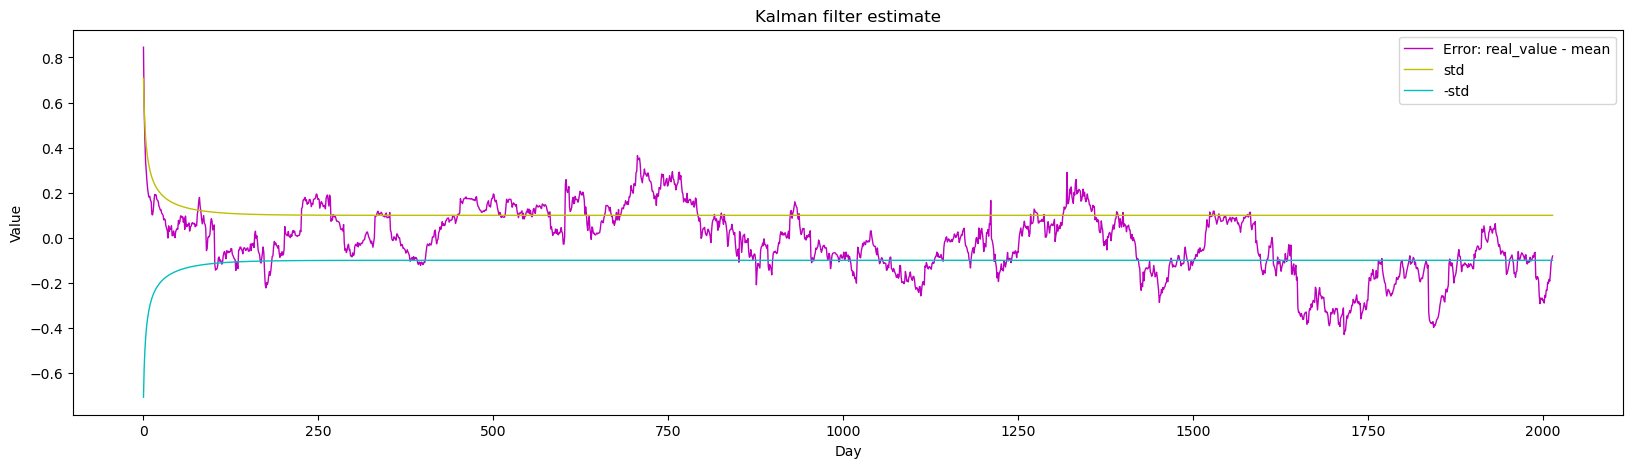

In [87]:
kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)

mean, cov = kf.filter(ratio.values)
mean, std = mean.squeeze(), np.std(cov.squeeze())


plt.figure(figsize=(20,5))
plt.plot(ratio.values - mean, 'm', lw=1)
plt.plot(np.sqrt(cov.squeeze()), 'y', lw=1)
plt.plot(-np.sqrt(cov.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

In [88]:
data['mean'] = mean.squeeze()
data['cov'] = cov.squeeze()
data['std'] = np.sqrt(data['cov'])
data = data.dropna()

data['ma'] = data['Ratio'].rolling(5).mean()
data['z_score'] = (data['ma'] - data['mean']) / data['std']

# Generate buy, sell and square off signals as: z<-0.1 buy, z>0.1 sell and -0.1<z<0.1 liquidate the position
data['position_1'] = np.nan
data['position_2'] = np.nan

for i in range(data.shape[0]):
    if data['z_score'].iloc[i] < -0.1:
        data['position_1'].iloc[i] = 1
        data['position_2'].iloc[i] = -round(data['Ratio'].iloc[i], 0)
    if data['z_score'].iloc[i] > 0.1:
        data['position_1'].iloc[i] = -1
        data['position_2'].iloc[i] = round(data['Ratio'].iloc[i], 0)
    if (abs(data['z_score'].iloc[i]) < 0.1) & (abs(data['z_score'].iloc[i]) > 0):
        data['position_1'].iloc[i] = 0
        data['position_2'].iloc[i] = 0


# Calculate returns
data['returns'] = ((data['ADBE'] - data['ADBE'].shift(1)) / data['ADBE'].shift(1)) * data['position_1'].shift(
    1) + ((data['MSFT'] - data['MSFT'].shift(1)) / data['MSFT'].shift(1)) * data['position_2'].shift(1)

total_returns = data['returns'].sum()
print("Total returns:", total_returns)

Total returns: 1.5089994009237244


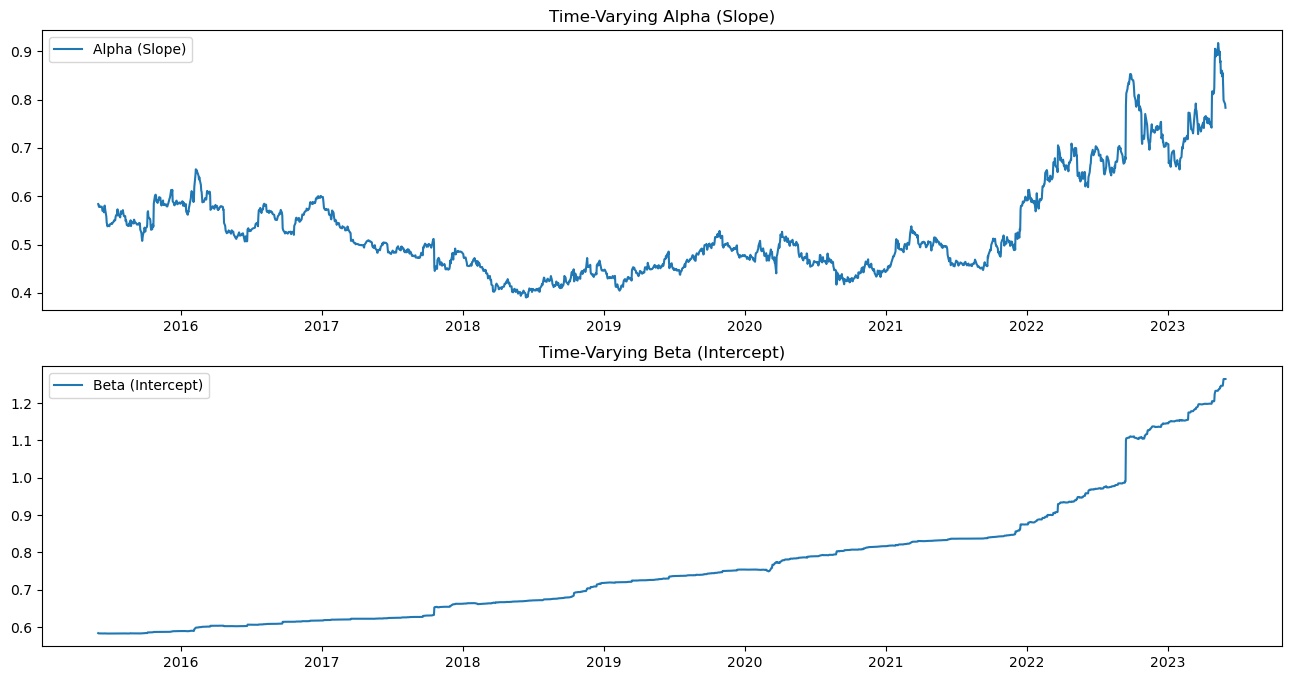

In [99]:
state_means = KalmanFilterRegression(ADBE, MSFT)

# Extract alpha (slope) and beta (intercept) estimates
alpha_estimates = state_means[:, 0]  # Time-varying slope (alpha)
beta_estimates = state_means[:, 1]   # Time-varying intercept (beta)

# Create a DataFrame to visualize the results
kalman_results = pd.DataFrame({'Alpha': alpha_estimates, 'Beta': beta_estimates}, index=MSFT.index)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))


# Plot time-varying alpha (slope)
plt.subplot(2, 1, 1)

plt.plot(kalman_results['Alpha'], label="Alpha (Slope)")
plt.legend()
plt.title("Time-Varying Alpha (Slope)")

# Plot time-varying beta (intercept)
plt.subplot(2, 1, 2)
plt.plot(kalman_results['Beta'], label="Beta (Intercept)")
plt.legend()
plt.title("Time-Varying Beta (Intercept)")

plt.show()


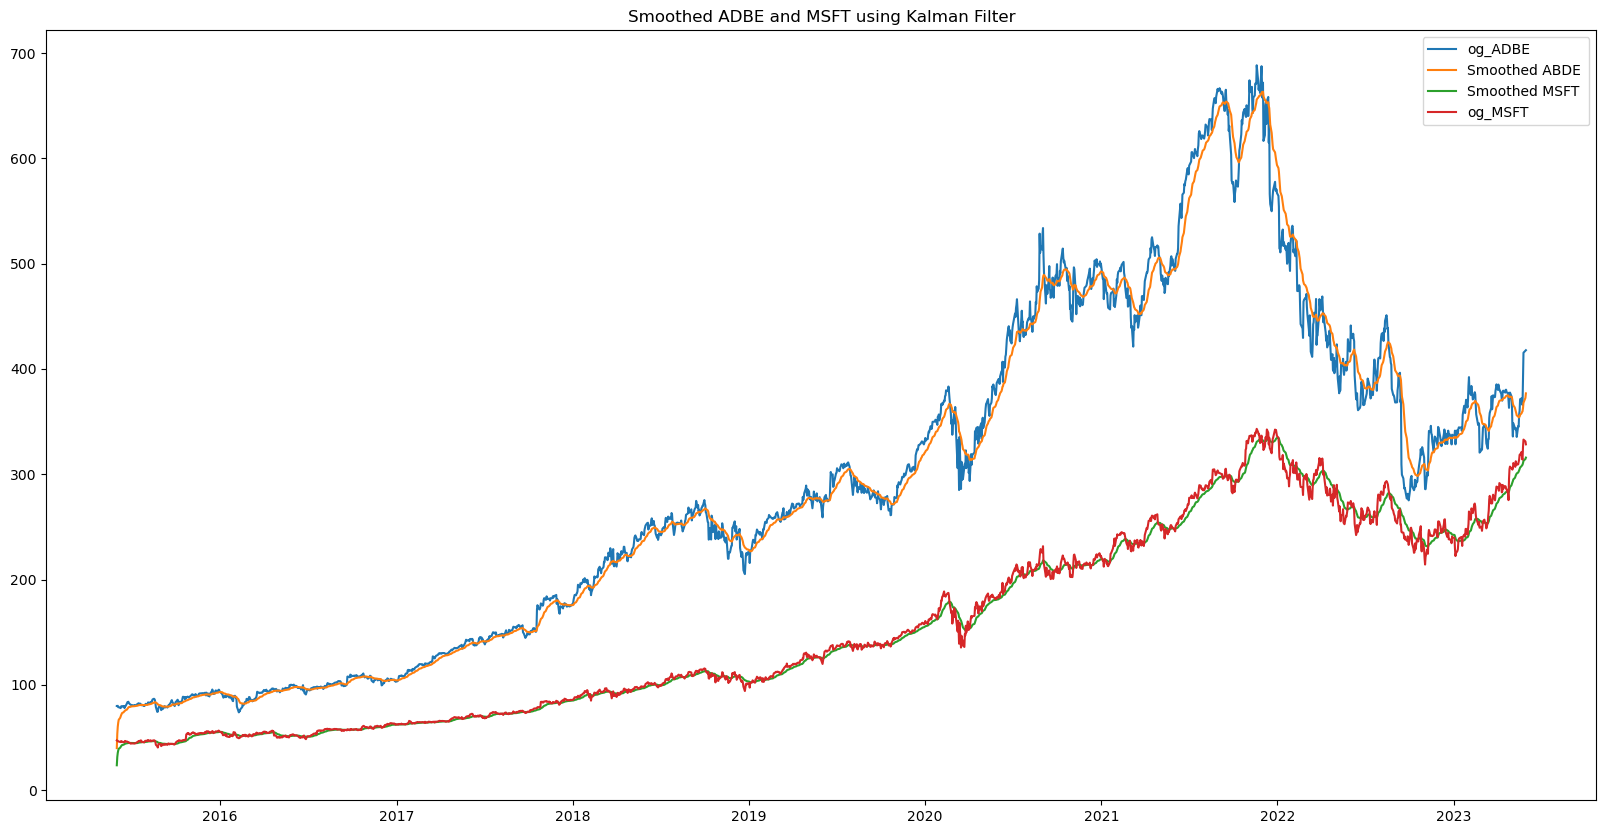

In [106]:
# Smooth the returns for both stocks using Kalman filter (rolling average)
smoothed_ADBE = KalmanFilterAverage(ADBE)
ratios_mavg5_ADBE = ADBE.rolling(window=5, center=False).mean()
ratios_mavg20_ADBE = ADBE.rolling(window=20, center=False).mean()

smoothed_MSFT = KalmanFilterAverage(MSFT)
ratios_mavg5_MSFT = MSFT.rolling(window=5, center=False).mean()
ratios_mavg20_MSFT = MSFT.rolling(window=20, center=False).mean()

# Plot the smoothed returns
plt.figure(figsize=(20, 10))
plt.plot(ADBE , label='og_ADBE')
plt.plot(smoothed_ADBE, label='Smoothed ABDE')
# plt.plot(ratios_mavg5_ADBE.index, ratios_mavg5_ADBE.values, label='5d MA' )
# plt.plot(ratios_mavg20_ADBE.index, ratios_mavg20_ADBE.values, label='20d MA')

plt.plot(smoothed_MSFT, label='Smoothed MSFT ')
plt.plot(MSFT , label='og_MSFT')
# plt.plot(ratios_mavg5_MSFT.index, ratios_mavg5_MSFT.values, label='5d MA')
# plt.plot(ratios_mavg20_MSFT.index, ratios_mavg20_MSFT.values, label='20d MA')
plt.legend()
plt.title("Smoothed ADBE and MSFT using Kalman Filter")
plt.show()


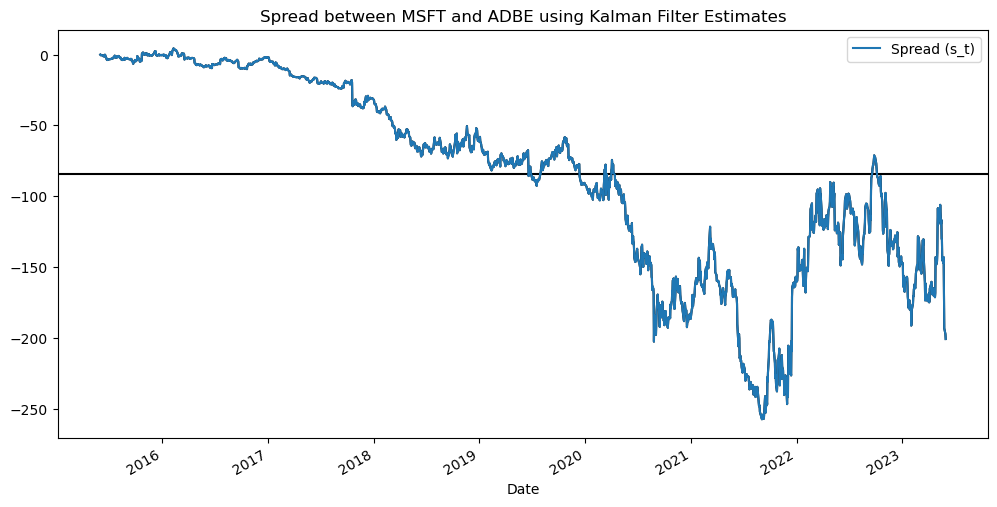

-84.13785283834798


In [91]:
# Calculate the spread s_t
spread = MSFT - (kalman_results['Alpha'] + kalman_results['Beta'] * ADBE)
plt.axhline(spread.mean(), color='black')
# Plot the spread
spread.plot(figsize=(12,6) , color = 'k')
plt.plot(spread, label="Spread (s_t)")
plt.legend()
plt.title("Spread between MSFT and ADBE using Kalman Filter Estimates")
plt.show()

print(spread.mean())

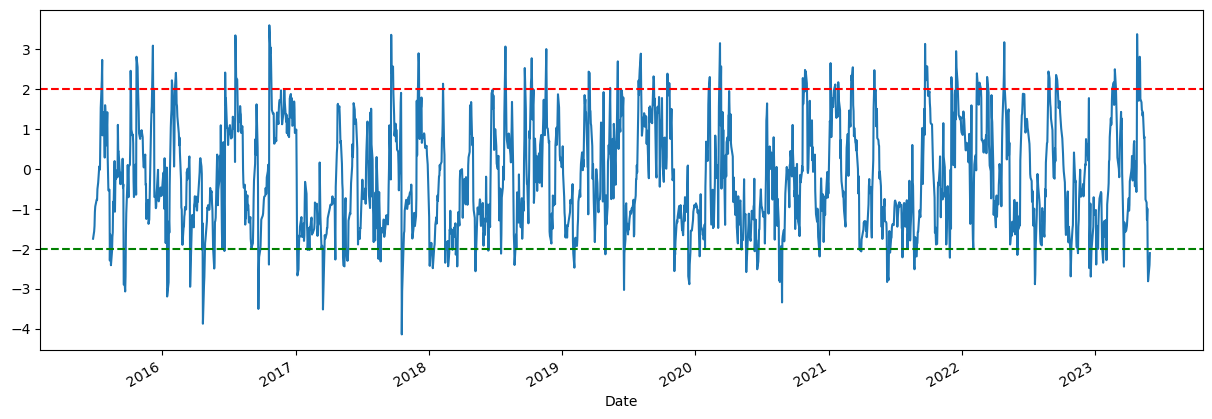

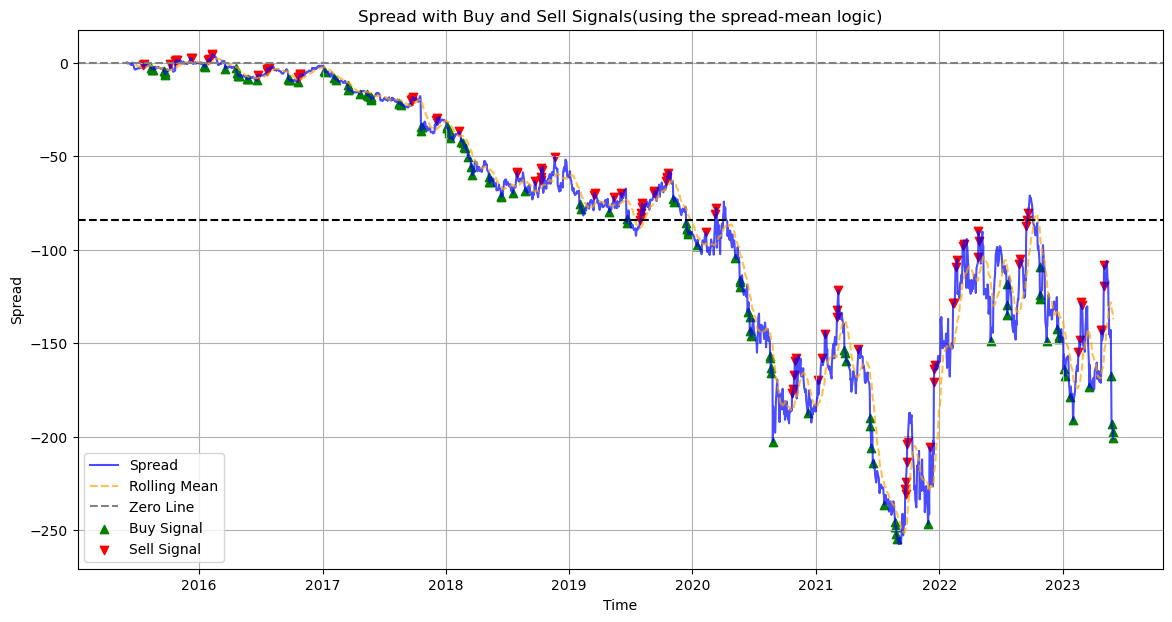

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'spread' is a pandas Series containing the spread values
# Parameters
window_size = 20  # Rolling window size for calculating mean and standard deviation
rolling_mean = spread.rolling(window=window_size).mean()
rolling_std = spread.rolling(window=window_size).std()

# Calculate the z-score
z_score = (spread - rolling_mean) / rolling_std
z_score.plot(figsize=(15,5))
plt.axhline(2, color='red', linestyle='--', label="Zero Line")
plt.axhline(-2, color='green', linestyle='--', label="Zero Line")

# Define the thresholds for the signals
buy_threshold = -2  # Buy when z-score is less than -2
sell_threshold = 2  # Sell when z-score is greater than 2

# Generate buy and sell signals
buy_signals = z_score < buy_threshold
sell_signals = z_score > sell_threshold

# Create a DataFrame for easier handling
signals_df = pd.DataFrame({
    'Spread': spread,
    'Rolling_Mean': rolling_mean,
    'Buy_Signal': buy_signals,
    'Sell_Signal': sell_signals
})

# Step 3: Plot the spread with buy/sell signals
plt.figure(figsize=(14, 7))
plt.plot(spread, label='Spread', color='blue', alpha=0.7)
plt.plot(rolling_mean, label='Rolling Mean', color='orange', linestyle='--', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--', label='Zero Line')

# Mark buy signals with green arrows
plt.scatter(signals_df.index[buy_signals], spread[buy_signals], marker='^', color='green', label='Buy Signal', alpha=1)

# Mark sell signals with red arrows
plt.scatter(signals_df.index[sell_signals], spread[sell_signals], marker='v', color='red', label='Sell Signal', alpha=1)

# Final plot adjustments
plt.title('Spread with Buy and Sell Signals(using the spread-mean logic)')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.axhline(spread.mean(), color='black',linestyle='--')
plt.legend()
plt.grid()
plt.show()


In [93]:

# Create the 'Signal' column based on 'Buy_Signal' and 'Sell_Signal'
signals_df['Signal'] = 0  # Default to 0 (Hold)
signals_df.loc[signals_df['Buy_Signal'], 'Signal'] = 1  # Set to 1 for Buy
signals_df.loc[signals_df['Sell_Signal'], 'Signal'] = 2  # Set to 2 for Sell

# Display the updated DataFrame
print(signals_df)



                Spread  Rolling_Mean  Buy_Signal  Sell_Signal  Signal
Date                                                                 
2015-06-01    0.014439           NaN       False        False       0
2015-06-02   -0.210999           NaN       False        False       0
2015-06-03   -0.444426           NaN       False        False       0
2015-06-04   -0.136794           NaN       False        False       0
2015-06-05   -0.415867           NaN       False        False       0
...                ...           ...         ...          ...     ...
2023-05-24 -142.969156   -128.195786       False        False       0
2023-05-25 -167.319666   -129.401543        True        False       1
2023-05-26 -193.138501   -131.639820        True        False       1
2023-05-30 -197.181982   -134.198057        True        False       1
2023-05-31 -200.742215   -137.239626        True        False       1

[2015 rows x 5 columns]


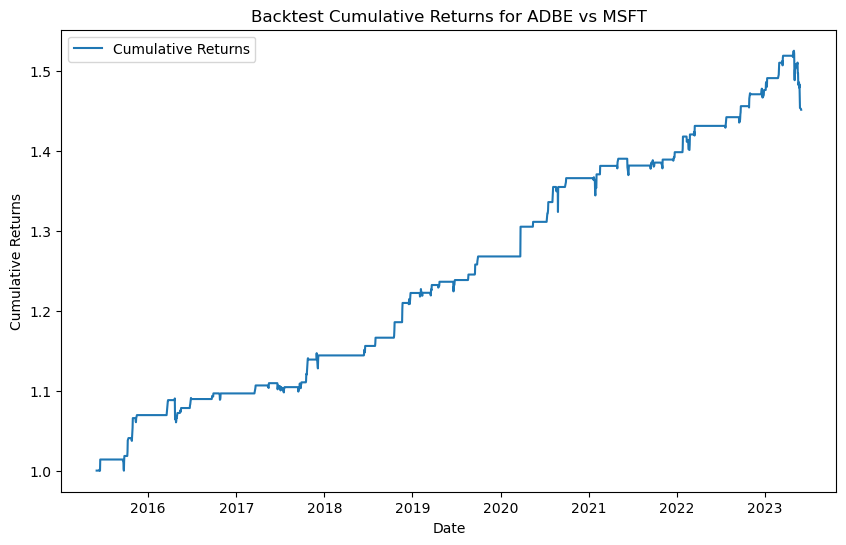

Sharpe Ratio: 1.37


In [94]:
# Run the backtest
cumulative_returns, sharpe_ratio = backtest('ADBE', 'MSFT', ADBE, MSFT)

# Plot the cumulative returns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Cumulative Returns")
plt.title("Backtest Cumulative Returns for ADBE vs MSFT")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Print the Sharpe ratio
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


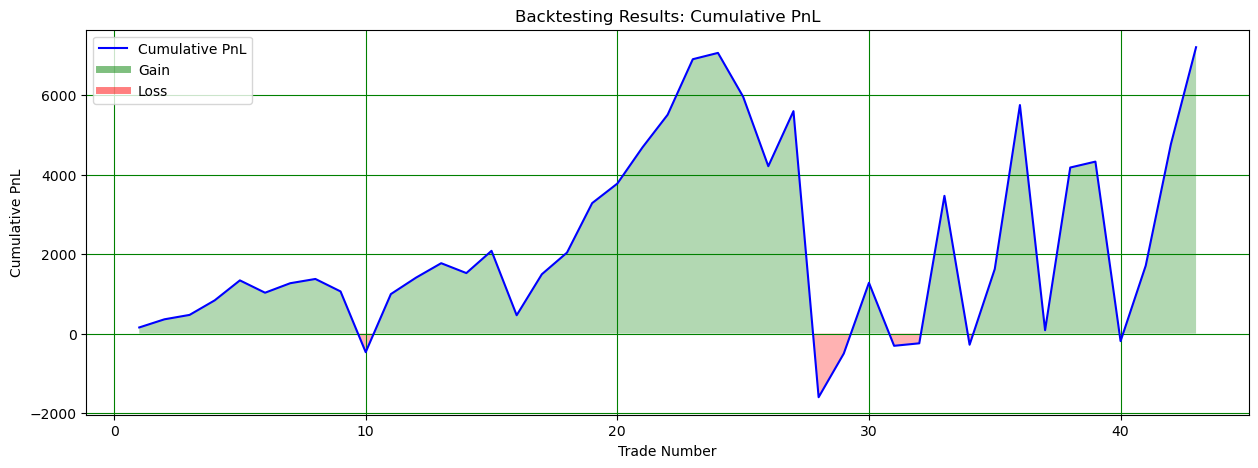

Final Cumulative PnL: 7205.196504129779
    Trade          PnL  Cumulative_PnL
0       1   154.305097      154.305097
1       2   204.776431      359.081527
2       3   110.927502      470.009030
3       4   366.737729      836.746759
4       5   502.101387     1338.848146
5       6  -310.506255     1028.341891
6       7   238.896741     1267.238632
7       8   107.157485     1374.396117
8       9  -313.550317     1060.845800
9      10 -1528.429213     -467.583413
10     11  1461.536757      993.953344
11     12   413.698445     1407.651789
12     13   363.238116     1770.889905
13     14  -248.451919     1522.437987
14     15   559.551222     2081.989209
15     16 -1620.407629      461.581580
16     17  1031.485581     1493.067161
17     18   544.637447     2037.704609
18     19  1245.273300     3282.977909
19     20   491.298683     3774.276592
20     21   910.837653     4685.114245
21     22   822.005907     5507.120151
22     23  1396.474000     6903.594151
23     24   158.747535  

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'signals_df' contains the following:
# - 'Spread': spread values
# - 'Buy_Signal': True for buy signals
# - 'Sell_Signal': True for sell signals

# Step 1: Simulate trading strategy
initial_balance = 100000  # Starting balance
position_size = 100  # Number of units bought/sold per trade
pnl = []  # List to store profit and loss for each trade
position = 0  # Current position (long/short)

for index, row in signals_df.iterrows():
    # If a buy signal is triggered
    if row['Buy_Signal']:
        if position == 0:  # No existing position
            entry_price = row['Spread']
            position = position_size  # Enter a long position
        elif position < 0:  # Close short position and go long
            pnl.append((entry_price - row['Spread']) * abs(position))
            entry_price = row['Spread']
            position = position_size
    
    # If a sell signal is triggered
    if row['Sell_Signal']:
        if position == 0:  # No existing position
            entry_price = row['Spread']
            position = -position_size  # Enter a short position
        elif position > 0:  # Close long position and go short
            pnl.append((row['Spread'] - entry_price) * position)
            entry_price = row['Spread']
            position = -position_size

# Step 2: Calculate cumulative PnL
cumulative_pnl = [sum(pnl[:i+1]) for i in range(len(pnl))]

# Step 3: Create a DataFrame to store trading results
backtest_df = pd.DataFrame({
    'Trade': range(1, len(cumulative_pnl) + 1),
    'PnL': pnl,
    'Cumulative_PnL': cumulative_pnl
})

# Step 4: Evaluate performance and plot cumulative PnL


plt.figure(figsize=(15, 5))
ax1 = plt.subplot()

# Plot cumulative PnL as a line
ax1.plot(backtest_df['Trade'], backtest_df['Cumulative_PnL'], '-', label='Cumulative PnL', color='blue')

# Legend placeholders for gain/loss shading
ax1.plot([], [], linewidth=5, label='Gain', color='g', alpha=0.5)
ax1.plot([], [], linewidth=5, label='Loss', color='r', alpha=0.5)

# Shading for gain/loss
ax1.fill_between(
    backtest_df['Trade'],
    backtest_df['Cumulative_PnL'],
    0,
    where=(backtest_df['Cumulative_PnL'] >= 0),
    facecolor='g',
    alpha=0.3,
    interpolate=True
)
ax1.fill_between(
    backtest_df['Trade'],
    backtest_df['Cumulative_PnL'],
    0,
    where=(backtest_df['Cumulative_PnL'] < 0),
    facecolor='r',
    alpha=0.3,
    interpolate=True
)

# Chart settings
plt.title('Backtesting Results: Cumulative PnL')
ax1.grid(True, color='g', linestyle='-')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()



# Print summary of results
print("Final Cumulative PnL:", cumulative_pnl[-1])
print(backtest_df)


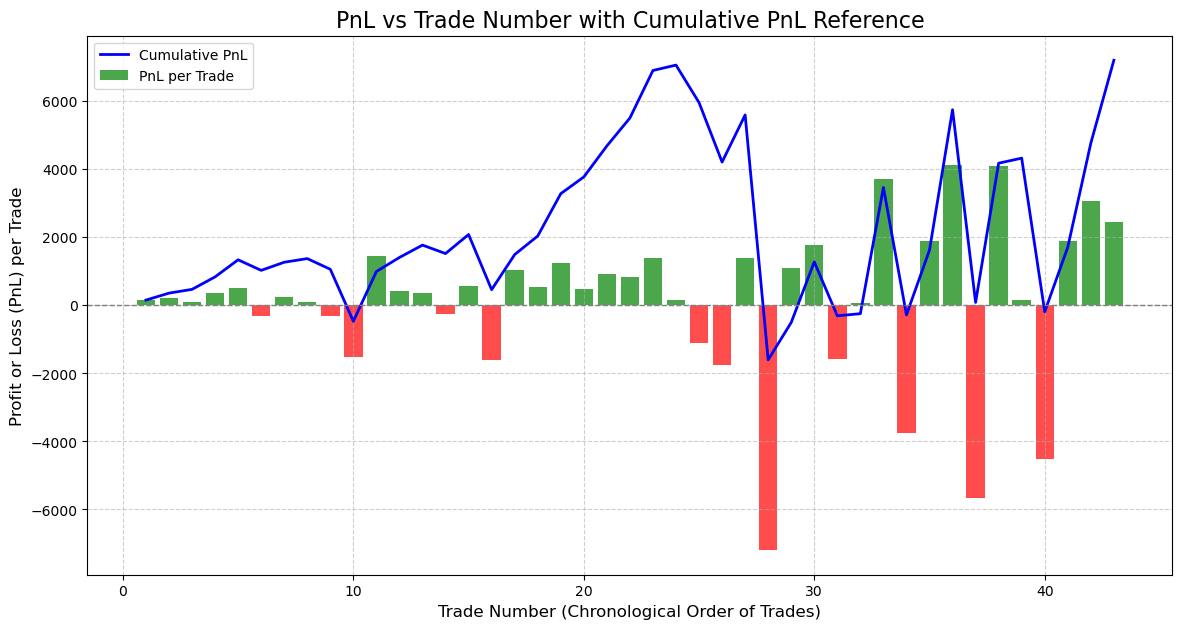

In [96]:
plt.figure(figsize=(14, 7))

# Plot PnL for each trade
plt.bar(backtest_df['Trade'], backtest_df['PnL'], 
        color=['g' if x >= 0 else 'r' for x in backtest_df['PnL']],
        alpha=0.7, label='PnL per Trade')

# Add cumulative PnL line for reference
plt.plot(backtest_df['Trade'], backtest_df['Cumulative_PnL'], 
         label='Cumulative PnL', color='blue', linewidth=2)

# Add horizontal zero line for reference
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Detailed X and Y labels
plt.title('PnL vs Trade Number with Cumulative PnL Reference', fontsize=16)
plt.xlabel('Trade Number (Chronological Order of Trades)', fontsize=12)
plt.ylabel('Profit or Loss (PnL) per Trade', fontsize=12)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()
